# Weather Analysis and Forecasting in Uberlândia

This notebook was developed to explore the forecasting of climatic variables for the city of **Uberlândia (MG)**, using historical data and the **XGBoost** model.  
The main objective is to simulate a practical short-term forecasting scenario, where the conditions for the next day are predicted based on the data available until the current day.

---

## Data Preparation and Treatment

We start by importing the essential libraries for analysis and modeling.  
Then, the data is loaded and prepared, including the combination of **Power Multilocation** information with climatic index data such as **SOI** and **ONI**.

To enrich the dataset, we perform a detailed **feature engineering** process, creating new variables that help the model capture seasonal and temporal patterns.

To demonstrate the methodology clearly and objectively, we filter the dataset to include only information from **Uberlândia**. The same logic, however, can be easily replicated for other cities.

---

## Training and Validation

The dataset is divided into two parts:

- **Training base**: from 2020 to 2024  
- **Validation base**: January to June 2025

We train an **XGBoost** regression model for each of the target variables:

- Maximum temperature (`T2M_MAX`)
- Minimum temperature (`T2M_MIN`)
- Average temperature (`T2M`)
- Relative humidity (`RH2M`)
- Wind speed (`WS2M`)

This approach allows each model to specialize in forecasting its respective variable.

---

## Daily Forecast Simulation

The forecast is made by simulating a real operational scenario, where the latest data is used to predict the next day.  
This methodology is ideal for **short-term predictions**, such as tomorrow's weather conditions.

> ⚠️ **Important**: this model **has not been optimized for long-term forecasts**.
O resultado final do processo é um **DataFrame contendo as previsões realizadas**, permitindo uma análise comparativa dos valores reais e previstos.


# 1. Data Acquisition and Manipulation

## Environment Setup and Library Import

This initial section sets up the working environment, ensuring that all necessary libraries are installed and imported. It includes packages for data manipulation (`pandas`, `numpy`), visualization (`matplotlib`, `seaborn`), and modeling (`xgboost`, `scikit-learn`).

Custom modules (`Endpoints`, `DataLoader`) are also imported for specific data loading and processing.


In [ ]:
# Setup
import sys, subprocess

def pip_install(pkgs):
    try:
        import importlib
        for p in pkgs:
            try:
                importlib.import_module(p.split("[")[0].replace("-","_"))
            except Exception:
                raise
        return
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", *pkgs])

pip_install([
    "pandas>=2.2.0",
    "numpy>=1.26",
    "scikit-learn>=1.4",
    "matplotlib>=3.8",
    "seaborn>=0.13",
    "xgboost>=1.7.0", # Added to use XGBoost
])

import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from xgboost import XGBRegressor # Import XGBoost

from endpoints import Endpoints # Import Endpoints
from data_loader import DataLoader # Import DataLoader

sns.set_theme(style="whitegrid")

endpoints = Endpoints()
data_loader = DataLoader(endpoints=endpoints)


## Data Loading and Preprocessing

In this step, raw data is loaded and prepared for feature engineering. It includes:

- **Consolidated daily data from NASA POWER (MultiLocation):** Contains various climatic variables.
- **ENSO index data (SOI, ONI):** Indicators of large-scale climatic phenomena.

The SOI and ONI indices are processed to ensure compatibility with daily data, including the creation of temporal lags to capture the influence of previous months.


In [ ]:
import pandas as pd

# Loading Datasets

# Define the search period (example: last 8 years)
end_date = pd.Timestamp.now().normalize()
start_date = end_date - timedelta(days=8*365)

# 1. Load consolidated daily data from NASA POWER (MultiLocation)
# Search for the most recent file containing "power_MultiLocation"
power_files = sorted(Path(".").glob("power_MultiLocation_*.csv"))
if not power_files:
    raise FileNotFoundError("No power_MultiLocation_*.csv file found. Run build_dataset.ipynb first.")

latest_power_file = power_files[-1]
print(f"Loading consolidated POWER data from: {latest_power_file.name}")
df_daily = pd.read_csv(latest_power_file, index_col='date', parse_dates=True)

# Note: If the 'power_MultiLocation_*.csv' file is not found,
# run the 'build_dataset.ipynb' notebook to generate the latest data.

print("POWER data loaded.")
print(df_daily.head())

# Load ENSO index data (SOI, ONI)
print("Loading SOI data...")
soi_data = data_loader.load_soi_data()
print("Loading ONI (Niño 3.4) data...")
on_data = data_loader.load_nino34_oni_data()

# Define target columns for forecasting (keep for future reference)
target_cols = ['WS2M']

print("All raw datasets loaded successfully.")

Carregando dados consolidados do POWER de: power_MultiLocation_2017-10-07_2025-10-05.csv
Dados POWER carregados.
            T2M_MAX  T2M_MIN    T2M   RH2M  WS2M  PRECTOTCORR  \
date                                                            
2017-10-07    26.17    24.09  24.91  77.24  4.38         2.48   
2017-10-08    26.15    24.00  24.85  77.25  4.84         1.26   
2017-10-09    26.22    23.70  24.86  75.37  4.76         0.40   
2017-10-10    25.92    23.33  24.56  77.75  4.39         0.38   
2017-10-11    25.64    23.65  24.52  79.67  4.65         0.23   

            ALLSKY_SFC_SW_DWN  ALLSKY_SFC_LW_DWN  T2MDEW      PS   QV2M  \
date                                                                      
2017-10-07              20.25              34.69   20.64  101.47  15.04   
2017-10-08              20.13              33.90   20.60  101.43  15.00   
2017-10-09              22.57              33.41   20.20  101.39  14.64   
2017-10-10              24.52              32.99   20.41

In [3]:
# Reseta o índice e já renomeia a coluna para 'date'
soi_data = soi_data.reset_index(names=['date'])
on_data = on_data.reset_index(names=['date'])

# Converte as datas para um objeto 'Period' (ano-mês)
soi_data['month_period'] = soi_data['date'].dt.to_period('M')
on_data['month_period'] = on_data['date'].dt.to_period('M')

In [4]:
soi_on_data = soi_data.merge(on_data[['date', 'ANOM']], how='inner', on='date')

In [5]:
# Crie os lags para a coluna SOI
soi_on_data['SOI_L1M'] = soi_on_data['SOI'].shift(1)
soi_on_data['SOI_L2M'] = soi_on_data['SOI'].shift(2)
soi_on_data['SOI_L3M'] = soi_on_data['SOI'].shift(3)

# Crie os lags para a coluna ANOM
soi_on_data['ANOM_L1M'] = soi_on_data['ANOM'].shift(1)
soi_on_data['ANOM_L2M'] = soi_on_data['ANOM'].shift(2)
soi_on_data['ANOM_L3M'] = soi_on_data['ANOM'].shift(3)

In [6]:
df_daily.head()

,T2M_MAX,T2M_MIN,T2M,RH2M,WS2M,PRECTOTCORR,ALLSKY_SFC_SW_DWN,ALLSKY_SFC_LW_DWN,T2MDEW,PS,QV2M,ALLSKY_KT,ALLSKY_SFC_SW_DIFF,TOA_SW_DWN,name,latitude,longitude
date,,,,,,,,,,,,,,,,,
2017-10-07,26.17,24.09,24.91,77.24,4.38,2.48,20.25,34.69,20.64,101.47,15.04,0.54,8.97,37.73,Aracaju,-10.9111,-37.0717
2017-10-08,26.15,24.00,24.85,77.25,4.84,1.26,20.13,33.90,20.60,101.43,15.00,0.53,10.42,37.80,Aracaju,-10.9111,-37.0717
2017-10-09,26.22,23.70,24.86,75.37,4.76,0.40,22.57,33.41,20.20,101.39,14.64,0.60,9.50,37.87,Aracaju,-10.9111,-37.0717
2017-10-10,25.92,23.33,24.56,77.75,4.39,0.38,24.52,32.99,20.41,101.37,14.84,0.65,7.80,37.93,Aracaju,-10.9111,-37.0717
2017-10-11,25.64,23.65,24.52,79.67,4.65,0.23,21.86,33.23,20.79,101.32,15.20,0.58,9.27,37.99,Aracaju,-10.9111,-37.0717


In [7]:
df_daily = df_daily.reset_index(names=['date'])
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily = df_daily[df_daily['date'] < '2025-06-30']
df_daily = df_daily.sort_values(by=['name', 'date'])

## Engenharia de Atributos (Feature Engineering)

Esta seção foca na criação de novas variáveis a partir dos dados existentes para melhorar o desempenho do modelo. As principais técnicas aplicadas são:

- **Criação de Lags Temporais:** Geramos lags para diversas variáveis climáticas, permitindo que o modelo capture a influência de dias anteriores na previsão. Os lags são calculados para períodos de 1 a 365 dias.
- **Variáveis de Sazonalidade:** Extraímos informações de data e hora, como mês, dia do ano, dia da semana e semana do ano. Além disso, criamos representações senoidais e cossenoidais para capturar padrões sazonais de forma contínua.
- **Combinação com Índices Climáticos:** Os dados de SOI e ONI (com seus respectivos lags) são mesclados ao dataset principal para adicionar informações sobre fenômenos climáticos de larga escala.


In [8]:
colunas = [
    'T2M_MAX', 'T2M_MIN', 'T2M', 'RH2M', 'WS2M', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN',
    'ALLSKY_SFC_LW_DWN', 'T2MDEW', 'PS', 'QV2M', 'ALLSKY_KT', 'ALLSKY_SFC_SW_DIFF', 'TOA_SW_DWN'
]

# Lista dos períodos de lag em dias
lags = [1, 2, 7, 15, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365]

# Crie um dicionário para armazenar as novas colunas de lag
lags_dict = {}

# Itere sobre cada coluna e crie as séries de lag
for coluna in colunas:
    for lag in lags:
        nome_lag = f'{coluna}_L{lag}D'
        # Armazena a nova série no dicionário
        lags_dict[nome_lag] = df_daily[coluna].shift(lag)

# Crie um novo DataFrame a partir do dicionário de lags
df_lags = pd.DataFrame(lags_dict)
df_daily = pd.concat([df_daily, df_lags], axis=1)
df_daily = df_daily[df_daily['date'] > '2020-01-01']

In [9]:
df_daily.head()

,date,T2M_MAX,T2M_MIN,T2M,RH2M,WS2M,PRECTOTCORR,ALLSKY_SFC_SW_DWN,ALLSKY_SFC_LW_DWN,T2MDEW,PS,QV2M,ALLSKY_KT,ALLSKY_SFC_SW_DIFF,TOA_SW_DWN,name,latitude,longitude,T2M_MAX_L1D,T2M_MAX_L2D,T2M_MAX_L7D,T2M_MAX_L15D,T2M_MAX_L30D,T2M_MAX_L60D,T2M_MAX_L90D,T2M_MAX_L120D,T2M_MAX_L150D,T2M_MAX_L180D,T2M_MAX_L210D,T2M_MAX_L240D,T2M_MAX_L270D,T2M_MAX_L300D,T2M_MAX_L330D,T2M_MAX_L365D,T2M_MIN_L1D,T2M_MIN_L2D,T2M_MIN_L7D,T2M_MIN_L15D,T2M_MIN_L30D,T2M_MIN_L60D,T2M_MIN_L90D,T2M_MIN_L120D,T2M_MIN_L150D,T2M_MIN_L180D,T2M_MIN_L210D,T2M_MIN_L240D,T2M_MIN_L270D,T2M_MIN_L300D,T2M_MIN_L330D,T2M_MIN_L365D,...,QV2M_L330D,QV2M_L365D,ALLSKY_KT_L1D,ALLSKY_KT_L2D,ALLSKY_KT_L7D,ALLSKY_KT_L15D,ALLSKY_KT_L30D,ALLSKY_KT_L60D,ALLSKY_KT_L90D,ALLSKY_KT_L120D,ALLSKY_KT_L150D,ALLSKY_KT_L180D,ALLSKY_KT_L210D,ALLSKY_KT_L240D,ALLSKY_KT_L270D,ALLSKY_KT_L300D,ALLSKY_KT_L330D,ALLSKY_KT_L365D,ALLSKY_SFC_SW_DIFF_L1D,ALLSKY_SFC_SW_DIFF_L2D,ALLSKY_SFC_SW_DIFF_L7D,ALLSKY_SFC_SW_DIFF_L15D,ALLSKY_SFC_SW_DIFF_L30D,ALLSKY_SFC_SW_DIFF_L60D,ALLSKY_SFC_SW_DIFF_L90D,ALLSKY_SFC_SW_DIFF_L120D,ALLSKY_SFC_SW_DIFF_L150D,ALLSKY_SFC_SW_DIFF_L180D,ALLSKY_SFC_SW_DIFF_L210D,ALLSKY_SFC_SW_DIFF_L240D,ALLSKY_SFC_SW_DIFF_L270D,ALLSKY_SFC_SW_DIFF_L300D,ALLSKY_SFC_SW_DIFF_L330D,ALLSKY_SFC_SW_DIFF_L365D,TOA_SW_DWN_L1D,TOA_SW_DWN_L2D,TOA_SW_DWN_L7D,TOA_SW_DWN_L15D,TOA_SW_DWN_L30D,TOA_SW_DWN_L60D,TOA_SW_DWN_L90D,TOA_SW_DWN_L120D,TOA_SW_DWN_L150D,TOA_SW_DWN_L180D,TOA_SW_DWN_L210D,TOA_SW_DWN_L240D,TOA_SW_DWN_L270D,TOA_SW_DWN_L300D,TOA_SW_DWN_L330D,TOA_SW_DWN_L365D
100131,2020-01-02,6.01,0.82,2.78,96.23,5.21,0.45,0.98,26.39,2.23,102.28,4.41,0.15,0.83,6.30,Amsterdã,52.3676,4.9041,1.64,7.53,5.54,5.54,7.60,11.45,13.80,18.61,23.06,19.52,17.31,12.08,18.26,8.82,4.83,7.01,0.09,1.37,4.12,4.37,4.61,8.22,7.94,14.63,17.88,12.15,12.37,6.63,7.70,6.22,1.00,3.18,...,4.59,4.12,0.22,0.53,0.22,0.41,0.39,0.29,0.20,0.24,0.51,0.30,0.52,0.42,0.58,0.53,0.19,0.29,1.11,1.85,1.18,1.52,1.36,2.78,3.04,4.84,9.51,9.35,11.59,10.48,7.02,4.57,1.80,1.34,6.24,6.20,6.03,6.01,6.79,11.44,19.28,28.25,36.09,40.84,40.97,36.35,28.38,19.14,11.17,6.31
100132,2020-01-03,8.45,4.83,6.71,92.00,5.50,7.24,0.78,26.55,5.51,101.71,5.58,0.12,0.68,6.35,Amsterdã,52.3676,4.9041,6.01,1.64,4.27,10.79,5.60,11.88,14.26,16.92,22.44,17.78,21.80,12.68,17.81,9.89,8.45,6.21,0.82,0.09,-0.09,5.41,0.66,7.87,7.01,12.11,16.72,11.62,10.98,6.52,6.90,6.37,4.62,3.48,...,5.20,4.49,0.15,0.22,0.58,0.30,0.55,0.27,0.48,0.47,0.55,0.43,0.40,0.23,0.62,0.35,0.52,0.43,0.83,1.11,1.13,1.58,1.16,2.23,6.26,8.54,11.68,11.65,11.38,6.82,6.13,5.15,3.19,1.41,6.30,6.24,6.05,6.00,6.71,11.22,18.99,27.95,35.87,40.75,41.04,36.56,28.68,19.45,11.39,6.37
100133,2020-01-04,7.51,5.18,6.42,91.83,4.66,0.89,1.48,26.01,5.21,102.81,5.38,0.23,1.27,6.42,Amsterdã,52.3676,4.9041,8.45,6.01,2.15,10.31,4.70,11.19,9.52,18.26,21.78,16.56,17.02,15.64,13.05,6.59,8.19,6.27,4.83,0.82,-0.45,7.15,0.57,7.90,7.91,12.32,15.94,12.00,12.51,7.53,5.47,2.78,4.37,3.76,...,5.56,4.83,0.12,0.15,0.32,0.17,0.28,0.29,0.16,0.31,0.58,0.42,0.30,0.58,0.65,0.15,0.18,0.10,0.68,0.83,1.69,0.90,1.42,2.48,2.60,7.25,10.45,12.49,8.98,9.26,7.22,2.39,1.81,0.58,6.35,6.30,6.08,5.99,6.63,11.01,18.70,27.66,35.64,40.65,41.12,36.78,28.98,19.75,11.61,6.43
100134,2020-01-05,7.40,5.57,6.14,94.12,3.45,0.48,0.74,27.29,5.28,103.18,5.37,0.11,0.58,6.48,Amsterdã,52.3676,4.9041,7.51,8.45,3.59,7.96,9.04,10.38,11.93,16.56,22.11,18.72,18.67,12.77,9.55,7.11,8.98,7.59,5.18,4.83,0.21,5.31,4.64,6.00,5.22,12.52,16.18,12.11,11.88,6.80,3.13,3.22,6.54,5.96,...,5.25,5.30,0.23,0.12,0.28,0.24,0.09,0.43,0.30,0.45,0.62,0.58,0.56,0.52,0.73,0.40,0.46,0.21,1.27,0.68,1.48,1.08,0.54,2.77,4.61,6.95,8.50,10.82,12.27,9.35,5.25,5.74,2.45,1.01,6.42,6.35,6.12,5.98,6.55,10.80,18.41,27.37,35.42,40.55,41.18,36.99,29.27,20.06,11.84,6.50
100135,2020-01-06,6.42,2.73,5.01,91.11,4.93,0.52,1.90,26.82,3.68,102.31,4.86,0.29,1.05,6.56,Amsterdã,52.3676,4.9041,7.40,7.51,6.09,8.23,9.04,9.24,16.38,17.63,25.21,18.14,20.87,13.04,9.54,8.44,7.44,7.07,5.57,5.18,1.01,4.98,6.47,5.61,11.69,11.88,15.80,11.94,13.24,5.22

In [10]:
df_daily['month_period'] = df_daily['date'].dt.to_period('M')
df_daily['prev_month_period'] = df_daily['month_period'] - 1

In [11]:
# Junta com os dados do SOI
df_daily_full = pd.merge(
    df_daily,
    soi_on_data[['month_period', 'SOI', 'SOI_L1M', 'SOI_L2M', 'SOI_L3M', 'ANOM', 'ANOM_L1M', 'ANOM_L2M', 'ANOM_L3M']],
    left_on='prev_month_period',
    right_on='month_period',
    how='left',
)
df_daily_full = df_daily_full.drop(columns=['month_period_y', 'month_period_x', 'prev_month_period'])

In [12]:
# 1. Variáveis de Sazonalidade Baseadas em Tempo

# Extrai o dia do ano, dia da semana, semana do ano e mês
df_daily_full['month'] = df_daily_full['date'].dt.month
df_daily_full['day_of_year'] = df_daily_full['date'].dt.dayofyear
df_daily_full['day_of_week'] = df_daily_full['date'].dt.dayofweek # 0=Monday, 6=Sunday
df_daily_full['week_of_year'] = df_daily_full['date'].dt.isocalendar().week.astype(int)

# Verifica se é fim de semana ou não
df_daily_full['is_weekend'] = (df_daily_full['date'].dt.weekday >= 5).astype(int)

# 2. Variáveis de Sazonalidade Contínua (Seno e Cosseno)

# Sazonalidade para o dia do ano (anual)
df_daily_full['day_of_year_sin'] = np.sin(2 * np.pi * df_daily_full['day_of_year'] / 365.25)
df_daily_full['day_of_year_cos'] = np.cos(2 * np.pi * df_daily_full['day_of_year'] / 365.25)

# Sazonalidade para a semana do ano (anual)
df_daily_full['week_of_year_sin'] = np.sin(2 * np.pi * df_daily_full['week_of_year'] / 52.0)
df_daily_full['week_of_year_cos'] = np.cos(2 * np.pi * df_daily_full['week_of_year'] / 52.0)

# Sazonalidade para o dia da semana (semanal)
df_daily_full['day_of_week_sin'] = np.sin(2 * np.pi * df_daily_full['day_of_week'] / 7.0)
df_daily_full['day_of_week_cos'] = np.cos(2 * np.pi * df_daily_full['day_of_week'] / 7.0)

# 3. Variáveis Adicionais (Ideias)
# Dependendo do seu problema, estas variáveis podem ser úteis:

# Sazonalidade para o mês
df_daily_full['month_sin'] = np.sin(2 * np.pi * df_daily_full['month'] / 12.0)
df_daily_full['month_cos'] = np.cos(2 * np.pi * df_daily_full['month'] / 12.0)

# Ano (se você tiver dados de vários anos)
df_daily_full['year'] = df_daily_full['date'].dt.year

In [13]:
df_daily_full.head()

,date,T2M_MAX,T2M_MIN,T2M,RH2M,WS2M,PRECTOTCORR,ALLSKY_SFC_SW_DWN,ALLSKY_SFC_LW_DWN,T2MDEW,PS,QV2M,ALLSKY_KT,ALLSKY_SFC_SW_DIFF,TOA_SW_DWN,name,latitude,longitude,T2M_MAX_L1D,T2M_MAX_L2D,T2M_MAX_L7D,T2M_MAX_L15D,T2M_MAX_L30D,T2M_MAX_L60D,T2M_MAX_L90D,T2M_MAX_L120D,T2M_MAX_L150D,T2M_MAX_L180D,T2M_MAX_L210D,T2M_MAX_L240D,T2M_MAX_L270D,T2M_MAX_L300D,T2M_MAX_L330D,T2M_MAX_L365D,T2M_MIN_L1D,T2M_MIN_L2D,T2M_MIN_L7D,T2M_MIN_L15D,T2M_MIN_L30D,T2M_MIN_L60D,T2M_MIN_L90D,T2M_MIN_L120D,T2M_MIN_L150D,T2M_MIN_L180D,T2M_MIN_L210D,T2M_MIN_L240D,T2M_MIN_L270D,T2M_MIN_L300D,T2M_MIN_L330D,T2M_MIN_L365D,...,ALLSKY_SFC_SW_DIFF_L30D,ALLSKY_SFC_SW_DIFF_L60D,ALLSKY_SFC_SW_DIFF_L90D,ALLSKY_SFC_SW_DIFF_L120D,ALLSKY_SFC_SW_DIFF_L150D,ALLSKY_SFC_SW_DIFF_L180D,ALLSKY_SFC_SW_DIFF_L210D,ALLSKY_SFC_SW_DIFF_L240D,ALLSKY_SFC_SW_DIFF_L270D,ALLSKY_SFC_SW_DIFF_L300D,ALLSKY_SFC_SW_DIFF_L330D,ALLSKY_SFC_SW_DIFF_L365D,TOA_SW_DWN_L1D,TOA_SW_DWN_L2D,TOA_SW_DWN_L7D,TOA_SW_DWN_L15D,TOA_SW_DWN_L30D,TOA_SW_DWN_L60D,TOA_SW_DWN_L90D,TOA_SW_DWN_L120D,TOA_SW_DWN_L150D,TOA_SW_DWN_L180D,TOA_SW_DWN_L210D,TOA_SW_DWN_L240D,TOA_SW_DWN_L270D,TOA_SW_DWN_L300D,TOA_SW_DWN_L330D,TOA_SW_DWN_L365D,SOI,SOI_L1M,SOI_L2M,SOI_L3M,ANOM,ANOM_L1M,ANOM_L2M,ANOM_L3M,month,day_of_year,day_of_week,week_of_year,is_weekend,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,year
0,2020-01-02,6.01,0.82,2.78,96.23,5.21,0.45,0.98,26.39,2.23,102.28,4.41,0.15,0.83,6.30,Amsterdã,52.3676,4.9041,1.64,7.53,5.54,5.54,7.6,11.45,13.80,18.61,23.06,19.52,17.31,12.08,18.26,8.82,4.83,7.01,0.09,1.37,4.12,4.37,4.61,8.22,7.94,14.63,17.88,12.15,12.37,6.63,7.70,6.22,1.00,3.18,...,1.36,2.78,3.04,4.84,9.51,9.35,11.59,10.48,7.02,4.57,1.80,1.34,6.24,6.20,6.03,6.01,6.79,11.44,19.28,28.25,36.09,40.84,40.97,36.35,28.38,19.14,11.17,6.31,-0.6,-0.8,-1.4,-0.4,0.55,0.51,0.51,0.35,1,2,3,1,0,0.034398,0.999408,0.120537,0.992709,0.433884,-0.900969,0.5,0.866025,2020
1,2020-01-02,6.01,0.82,2.78,96.23,5.21,0.45,0.98,26.39,2.23,102.28,4.41,0.15,0.83,6.30,Amsterdã,52.3676,4.9041,1.64,7.53,5.54,5.54,7.6,11.45,13.80,18.61,23.06,19.52,17.31,12.08,18.26,8.82,4.83,7.01,0.09,1.37,4.12,4.37,4.61,8.22,7.94,14.63,17.88,12.15,12.37,6.63,7.70,6.22,1.00,3.18,...,1.36,2.78,3.04,4.84,9.51,9.35,11.59,10.48,7.02,4.57,1.80,1.34,6.24,6.20,6.03,6.01,6.79,11.44,19.28,28.25,36.09,40.84,40.97,36.35,28.38,19.14,11.17,6.31,-0.9,-0.6,-0.8,-1.4,0.55,0.55,0.51,0.51,1,2,3,1,0,0.034398,0.999408,0.120537,0.992709,0.433884,-0.900969,0.5,0.866025,2020
2,2020-01-03,8.45,4.83,6.71,92.00,5.50,7.24,0.78,26.55,5.51,101.71,5.58,0.12,0.68,6.35,Amsterdã,52.3676,4.9041,6.01,1.64,4.27,10.79,5.6,11.88,14.26,16.92,22.44,17.78,21.80,12.68,17.81,9.89,8.45,6.21,0.82,0.09,-0.09,5.41,0.66,7.87,7.01,12.11,16.72,11.62,10.98,6.52,6.90,6.37,4.62,3.48,...,1.16,2.23,6.26,8.54,11.68,11.65,11.38,6.82,6.13,5.15,3.19,1.41,6.30,6.24,6.05,6.00,6.71,11.22,18.99,27.95,35.87,40.75,41.04,36.56,28.68,19.45,11.39,6.37,-0.6,-0.8,-1.4,-0.4,0.55,0.51,0.51,0.35,1,3,4,1,0,0.051584,0.998669,0.120537,0.992709,-0.433884,-0.900969,0.5,0.866025,2020
3,2020-01-03,8.45,4.83,6.71,92.00,5.50,7.24,0.78,26.55,5.51,101.71,5.58,0.12,0.68,6.35,Amsterdã,52.3676,4.9041,6.01,1.64,4.27,10.79,5.6,11.88,14.26,16.92,22.44,17.78,21.80,12.68,17.81,9.89,8.45,6.21,0.82,0.09,-0.09,5.41,0.66,7.87,7.01,12.11,16.72,11.62,10.98,6.52,6.90,6.37,4.62,3.48,...,1.16,2.23,6.26,8.54,11.68,11.65,11.38,6.82,6.13,5.15,3.19,1.41,6.30,6.24,6.05,6.00,6.71,11.22,18.99,27.95,35.87,40.75,41.04,36.56,28.68,19.45,11.39,6.37,-0.9,-0.6,-0.8,-1.4,0.55,0.55,0.51,0.51,1,3,4,1,0,0.051584,0.998669,0.120537,0.992709,-0.433884,-0.900969,0.5,0.866025,2020
4,2020-01-04,7.51,5.18,6.42,91.83,4.66,0.89,1.48,26.01,5.21,102.81,5.38,0.23,1.27,6.42,Amsterdã,52.3676,4.9041,8.45,6.01,2.15,10.31,4.7,11.19,9.52,18.26,21.78,16.56,17.02,15.64,13.05,6.59,8.19,6.27,4.83,0.82,-0.45,7.15,0.57,7.90,7.91,12.32,15.94,12.00,12.51,7.53,5.47,2.78,4.37,3.76,...,1.42,2.48,2.60,7.25,10.45,12.49,8.98,9.26,7.22,2.39,1.81,0.58,6.35,6.3

## Seleção e Filtragem de Dados

Nesta fase, removemos colunas que não são relevantes para o treinamento do modelo e filtramos o dataset para incluir apenas os dados da cidade de Uberlândia. Além disso, dividimos o conjunto de dados em treinamento e validação para avaliar o desempenho do modelo.

- **Remoção de Colunas:** Colunas com informações redundantes ou irrelevantes são descartadas.
- **Filtragem por Localização:** O dataset é filtrado para conter apenas os dados correspondentes a Uberlândia.
- **Divisão Treino/Validação:** Os dados são separados em um conjunto de treinamento (até o final de 2024) e um conjunto de validação (janeiro a junho de 2025) para simular o cenário de previsão.


In [14]:
# Lista das colunas para remover
colunas_a_remover = [
    'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_LW_DWN',
    'T2MDEW', 'PS', 'QV2M', 'ALLSKY_KT', 'ALLSKY_SFC_SW_DIFF', 'TOA_SW_DWN'
]

df = df_daily_full.drop(columns=colunas_a_remover)

In [15]:
df.head()

,date,T2M_MAX,T2M_MIN,T2M,RH2M,WS2M,name,latitude,longitude,T2M_MAX_L1D,T2M_MAX_L2D,T2M_MAX_L7D,T2M_MAX_L15D,T2M_MAX_L30D,T2M_MAX_L60D,T2M_MAX_L90D,T2M_MAX_L120D,T2M_MAX_L150D,T2M_MAX_L180D,T2M_MAX_L210D,T2M_MAX_L240D,T2M_MAX_L270D,T2M_MAX_L300D,T2M_MAX_L330D,T2M_MAX_L365D,T2M_MIN_L1D,T2M_MIN_L2D,T2M_MIN_L7D,T2M_MIN_L15D,T2M_MIN_L30D,T2M_MIN_L60D,T2M_MIN_L90D,T2M_MIN_L120D,T2M_MIN_L150D,T2M_MIN_L180D,T2M_MIN_L210D,T2M_MIN_L240D,T2M_MIN_L270D,T2M_MIN_L300D,T2M_MIN_L330D,T2M_MIN_L365D,T2M_L1D,T2M_L2D,T2M_L7D,T2M_L15D,T2M_L30D,T2M_L60D,T2M_L90D,T2M_L120D,T2M_L150D,...,ALLSKY_SFC_SW_DIFF_L30D,ALLSKY_SFC_SW_DIFF_L60D,ALLSKY_SFC_SW_DIFF_L90D,ALLSKY_SFC_SW_DIFF_L120D,ALLSKY_SFC_SW_DIFF_L150D,ALLSKY_SFC_SW_DIFF_L180D,ALLSKY_SFC_SW_DIFF_L210D,ALLSKY_SFC_SW_DIFF_L240D,ALLSKY_SFC_SW_DIFF_L270D,ALLSKY_SFC_SW_DIFF_L300D,ALLSKY_SFC_SW_DIFF_L330D,ALLSKY_SFC_SW_DIFF_L365D,TOA_SW_DWN_L1D,TOA_SW_DWN_L2D,TOA_SW_DWN_L7D,TOA_SW_DWN_L15D,TOA_SW_DWN_L30D,TOA_SW_DWN_L60D,TOA_SW_DWN_L90D,TOA_SW_DWN_L120D,TOA_SW_DWN_L150D,TOA_SW_DWN_L180D,TOA_SW_DWN_L210D,TOA_SW_DWN_L240D,TOA_SW_DWN_L270D,TOA_SW_DWN_L300D,TOA_SW_DWN_L330D,TOA_SW_DWN_L365D,SOI,SOI_L1M,SOI_L2M,SOI_L3M,ANOM,ANOM_L1M,ANOM_L2M,ANOM_L3M,month,day_of_year,day_of_week,week_of_year,is_weekend,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,year
0,2020-01-02,6.01,0.82,2.78,96.23,5.21,Amsterdã,52.3676,4.9041,1.64,7.53,5.54,5.54,7.6,11.45,13.80,18.61,23.06,19.52,17.31,12.08,18.26,8.82,4.83,7.01,0.09,1.37,4.12,4.37,4.61,8.22,7.94,14.63,17.88,12.15,12.37,6.63,7.70,6.22,1.00,3.18,0.89,4.88,4.83,5.00,6.06,9.96,10.03,16.70,20.42,...,1.36,2.78,3.04,4.84,9.51,9.35,11.59,10.48,7.02,4.57,1.80,1.34,6.24,6.20,6.03,6.01,6.79,11.44,19.28,28.25,36.09,40.84,40.97,36.35,28.38,19.14,11.17,6.31,-0.6,-0.8,-1.4,-0.4,0.55,0.51,0.51,0.35,1,2,3,1,0,0.034398,0.999408,0.120537,0.992709,0.433884,-0.900969,0.5,0.866025,2020
1,2020-01-02,6.01,0.82,2.78,96.23,5.21,Amsterdã,52.3676,4.9041,1.64,7.53,5.54,5.54,7.6,11.45,13.80,18.61,23.06,19.52,17.31,12.08,18.26,8.82,4.83,7.01,0.09,1.37,4.12,4.37,4.61,8.22,7.94,14.63,17.88,12.15,12.37,6.63,7.70,6.22,1.00,3.18,0.89,4.88,4.83,5.00,6.06,9.96,10.03,16.70,20.42,...,1.36,2.78,3.04,4.84,9.51,9.35,11.59,10.48,7.02,4.57,1.80,1.34,6.24,6.20,6.03,6.01,6.79,11.44,19.28,28.25,36.09,40.84,40.97,36.35,28.38,19.14,11.17,6.31,-0.9,-0.6,-0.8,-1.4,0.55,0.55,0.51,0.51,1,2,3,1,0,0.034398,0.999408,0.120537,0.992709,0.433884,-0.900969,0.5,0.866025,2020
2,2020-01-03,8.45,4.83,6.71,92.00,5.50,Amsterdã,52.3676,4.9041,6.01,1.64,4.27,10.79,5.6,11.88,14.26,16.92,22.44,17.78,21.80,12.68,17.81,9.89,8.45,6.21,0.82,0.09,-0.09,5.41,0.66,7.87,7.01,12.11,16.72,11.62,10.98,6.52,6.90,6.37,4.62,3.48,2.78,0.89,2.41,8.23,3.36,9.35,10.27,15.01,19.45,...,1.16,2.23,6.26,8.54,11.68,11.65,11.38,6.82,6.13,5.15,3.19,1.41,6.30,6.24,6.05,6.00,6.71,11.22,18.99,27.95,35.87,40.75,41.04,36.56,28.68,19.45,11.39,6.37,-0.6,-0.8,-1.4,-0.4,0.55,0.51,0.51,0.35,1,3,4,1,0,0.051584,0.998669,0.120537,0.992709,-0.433884,-0.900969,0.5,0.866025,2020
3,2020-01-03,8.45,4.83,6.71,92.00,5.50,Amsterdã,52.3676,4.9041,6.01,1.64,4.27,10.79,5.6,11.88,14.26,16.92,22.44,17.78,21.80,12.68,17.81,9.89,8.45,6.21,0.82,0.09,-0.09,5.41,0.66,7.87,7.01,12.11,16.72,11.62,10.98,6.52,6.90,6.37,4.62,3.48,2.78,0.89,2.41,8.23,3.36,9.35,10.27,15.01,19.45,...,1.16,2.23,6.26,8.54,11.68,11.65,11.38,6.82,6.13,5.15,3.19,1.41,6.30,6.24,6.05,6.00,6.71,11.22,18.99,27.95,35.87,40.75,41.04,36.56,28.68,19.45,11.39,6.37,-0.9,-0.6,-0.8,-1.4,0.55,0.55,0.51,0.51,1,3,4,1,0,0.051584,0.998669,0.120537,0.992709,-0.433884,-0.900969,0.5,0.866025,2020
4,2020-01-04,7.51,5.18,6.42,91.83,4.66,Amsterdã,52.3676,4.9041,8.45,6.01,2.15,10.31,4.7,11.19,9.52,18.26,21.78,16.56,17.02,15.64,13.05,6.59,8.19,6.27,4.83,0.82,-0.45,7.15,0.57,7.90,7.91,12.32,15.94,12.00,12.51,7.53,5.47,2.78,4.37,3.76,6.71,2.78,0.66,8.59,3.17,9.25,8.72,15.32,19.16,...,1.42,2.48,2.60,7.25,10.45,12.49,8.98,9.26,7.22,2.39,1.81,0.58,6.35,6.30,6.08,5.99,6.63,11.01,1

In [16]:
train_end_date = '2024-12-31'
valid_end_date = '2025-06-29'

train = df[df['date'] <= train_end_date].copy()
valid = df[df['date'] > train_end_date].copy()

In [17]:
train_udi = train[train['name'] == 'Uberlândia']
valid_udi = valid[valid['name'] == 'Uberlândia']

train_udi.shape, valid_udi.shape

((3652, 255), (211, 255))

In [18]:
train_udi.head(2)

,date,T2M_MAX,T2M_MIN,T2M,RH2M,WS2M,name,latitude,longitude,T2M_MAX_L1D,T2M_MAX_L2D,T2M_MAX_L7D,T2M_MAX_L15D,T2M_MAX_L30D,T2M_MAX_L60D,T2M_MAX_L90D,T2M_MAX_L120D,T2M_MAX_L150D,T2M_MAX_L180D,T2M_MAX_L210D,T2M_MAX_L240D,T2M_MAX_L270D,T2M_MAX_L300D,T2M_MAX_L330D,T2M_MAX_L365D,T2M_MIN_L1D,T2M_MIN_L2D,T2M_MIN_L7D,T2M_MIN_L15D,T2M_MIN_L30D,T2M_MIN_L60D,T2M_MIN_L90D,T2M_MIN_L120D,T2M_MIN_L150D,T2M_MIN_L180D,T2M_MIN_L210D,T2M_MIN_L240D,T2M_MIN_L270D,T2M_MIN_L300D,T2M_MIN_L330D,T2M_MIN_L365D,T2M_L1D,T2M_L2D,T2M_L7D,T2M_L15D,T2M_L30D,T2M_L60D,T2M_L90D,T2M_L120D,T2M_L150D,...,ALLSKY_SFC_SW_DIFF_L30D,ALLSKY_SFC_SW_DIFF_L60D,ALLSKY_SFC_SW_DIFF_L90D,ALLSKY_SFC_SW_DIFF_L120D,ALLSKY_SFC_SW_DIFF_L150D,ALLSKY_SFC_SW_DIFF_L180D,ALLSKY_SFC_SW_DIFF_L210D,ALLSKY_SFC_SW_DIFF_L240D,ALLSKY_SFC_SW_DIFF_L270D,ALLSKY_SFC_SW_DIFF_L300D,ALLSKY_SFC_SW_DIFF_L330D,ALLSKY_SFC_SW_DIFF_L365D,TOA_SW_DWN_L1D,TOA_SW_DWN_L2D,TOA_SW_DWN_L7D,TOA_SW_DWN_L15D,TOA_SW_DWN_L30D,TOA_SW_DWN_L60D,TOA_SW_DWN_L90D,TOA_SW_DWN_L120D,TOA_SW_DWN_L150D,TOA_SW_DWN_L180D,TOA_SW_DWN_L210D,TOA_SW_DWN_L240D,TOA_SW_DWN_L270D,TOA_SW_DWN_L300D,TOA_SW_DWN_L330D,TOA_SW_DWN_L365D,SOI,SOI_L1M,SOI_L2M,SOI_L3M,ANOM,ANOM_L1M,ANOM_L2M,ANOM_L3M,month,day_of_year,day_of_week,week_of_year,is_weekend,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,year
139068,2020-01-02,26.56,19.8,23.26,84.04,1.22,Uberlândia,-18.9186,-48.2772,28.59,28.58,29.38,29.55,28.96,31.37,34.26,34.8,23.56,20.97,23.77,28.27,26.38,28.35,28.58,28.56,19.13,20.1,19.24,19.04,19.66,18.98,18.79,19.68,14.24,7.55,10.17,19.44,19.99,19.37,20.07,19.18,24.02,24.37,24.28,23.73,24.2,25.58,25.7,26.61,18.1,...,8.18,9.4,3.51,3.29,6.39,2.8,2.61,4.36,7.46,7.17,9.21,8.35,41.68,41.68,41.69,41.66,41.38,39.89,36.79,32.36,27.88,25.04,25.14,28.22,32.96,37.5,40.46,41.67,-0.6,-0.8,-1.4,-0.4,0.55,0.51,0.51,0.35,1,2,3,1,0,0.034398,0.999408,0.120537,0.992709,0.433884,-0.900969,0.5,0.866025,2020
139069,2020-01-02,26.56,19.8,23.26,84.04,1.22,Uberlândia,-18.9186,-48.2772,28.59,28.58,29.38,29.55,28.96,31.37,34.26,34.8,23.56,20.97,23.77,28.27,26.38,28.35,28.58,28.56,19.13,20.1,19.24,19.04,19.66,18.98,18.79,19.68,14.24,7.55,10.17,19.44,19.99,19.37,20.07,19.18,24.02,24.37,24.28,23.73,24.2,25.58,25.7,26.61,18.1,...,8.18,9.4,3.51,3.29,6.39,2.8,2.61,4.36,7.46,7.17,9.21,8.35,41.68,41.68,41.69,41.66,41.38,39.89,36.79,32.36,27.88,25.04,25.14,28.22,32.96,37.5,40.46,41.67,-0.9,-0.6,-0.8,-1.4,0.55,0.55,0.51,0.51,1,2,3,1,0,0.034398,0.999408,0.120537,0.992709,0.433884,-0.900969,0.5,0.866025,2020


# 2. Treinamento e Previsão do Modelo

## Função de Treinamento do Modelo

In [19]:
train_udi.head()

,date,T2M_MAX,T2M_MIN,T2M,RH2M,WS2M,name,latitude,longitude,T2M_MAX_L1D,T2M_MAX_L2D,T2M_MAX_L7D,T2M_MAX_L15D,T2M_MAX_L30D,T2M_MAX_L60D,T2M_MAX_L90D,T2M_MAX_L120D,T2M_MAX_L150D,T2M_MAX_L180D,T2M_MAX_L210D,T2M_MAX_L240D,T2M_MAX_L270D,T2M_MAX_L300D,T2M_MAX_L330D,T2M_MAX_L365D,T2M_MIN_L1D,T2M_MIN_L2D,T2M_MIN_L7D,T2M_MIN_L15D,T2M_MIN_L30D,T2M_MIN_L60D,T2M_MIN_L90D,T2M_MIN_L120D,T2M_MIN_L150D,T2M_MIN_L180D,T2M_MIN_L210D,T2M_MIN_L240D,T2M_MIN_L270D,T2M_MIN_L300D,T2M_MIN_L330D,T2M_MIN_L365D,T2M_L1D,T2M_L2D,T2M_L7D,T2M_L15D,T2M_L30D,T2M_L60D,T2M_L90D,T2M_L120D,T2M_L150D,...,ALLSKY_SFC_SW_DIFF_L30D,ALLSKY_SFC_SW_DIFF_L60D,ALLSKY_SFC_SW_DIFF_L90D,ALLSKY_SFC_SW_DIFF_L120D,ALLSKY_SFC_SW_DIFF_L150D,ALLSKY_SFC_SW_DIFF_L180D,ALLSKY_SFC_SW_DIFF_L210D,ALLSKY_SFC_SW_DIFF_L240D,ALLSKY_SFC_SW_DIFF_L270D,ALLSKY_SFC_SW_DIFF_L300D,ALLSKY_SFC_SW_DIFF_L330D,ALLSKY_SFC_SW_DIFF_L365D,TOA_SW_DWN_L1D,TOA_SW_DWN_L2D,TOA_SW_DWN_L7D,TOA_SW_DWN_L15D,TOA_SW_DWN_L30D,TOA_SW_DWN_L60D,TOA_SW_DWN_L90D,TOA_SW_DWN_L120D,TOA_SW_DWN_L150D,TOA_SW_DWN_L180D,TOA_SW_DWN_L210D,TOA_SW_DWN_L240D,TOA_SW_DWN_L270D,TOA_SW_DWN_L300D,TOA_SW_DWN_L330D,TOA_SW_DWN_L365D,SOI,SOI_L1M,SOI_L2M,SOI_L3M,ANOM,ANOM_L1M,ANOM_L2M,ANOM_L3M,month,day_of_year,day_of_week,week_of_year,is_weekend,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,year
139068,2020-01-02,26.56,19.80,23.26,84.04,1.22,Uberlândia,-18.9186,-48.2772,28.59,28.58,29.38,29.55,28.96,31.37,34.26,34.80,23.56,20.97,23.77,28.27,26.38,28.35,28.58,28.56,19.13,20.10,19.24,19.04,19.66,18.98,18.79,19.68,14.24,7.55,10.17,19.44,19.99,19.37,20.07,19.18,24.02,24.37,24.28,23.73,24.20,25.58,25.70,26.61,18.10,...,8.18,9.40,3.51,3.29,6.39,2.80,2.61,4.36,7.46,7.17,9.21,8.35,41.68,41.68,41.69,41.66,41.38,39.89,36.79,32.36,27.88,25.04,25.14,28.22,32.96,37.50,40.46,41.67,-0.6,-0.8,-1.4,-0.4,0.55,0.51,0.51,0.35,1,2,3,1,0,0.034398,0.999408,0.120537,0.992709,0.433884,-0.900969,0.5,0.866025,2020
139069,2020-01-02,26.56,19.80,23.26,84.04,1.22,Uberlândia,-18.9186,-48.2772,28.59,28.58,29.38,29.55,28.96,31.37,34.26,34.80,23.56,20.97,23.77,28.27,26.38,28.35,28.58,28.56,19.13,20.10,19.24,19.04,19.66,18.98,18.79,19.68,14.24,7.55,10.17,19.44,19.99,19.37,20.07,19.18,24.02,24.37,24.28,23.73,24.20,25.58,25.70,26.61,18.10,...,8.18,9.40,3.51,3.29,6.39,2.80,2.61,4.36,7.46,7.17,9.21,8.35,41.68,41.68,41.69,41.66,41.38,39.89,36.79,32.36,27.88,25.04,25.14,28.22,32.96,37.50,40.46,41.67,-0.9,-0.6,-0.8,-1.4,0.55,0.55,0.51,0.51,1,2,3,1,0,0.034398,0.999408,0.120537,0.992709,0.433884,-0.900969,0.5,0.866025,2020
139070,2020-01-03,27.11,19.64,23.07,84.83,2.34,Uberlândia,-18.9186,-48.2772,26.56,28.59,27.67,26.94,25.35,32.49,34.28,34.88,25.75,22.70,23.89,28.13,22.88,29.76,28.60,28.34,19.80,19.13,20.34,18.98,20.63,20.30,19.92,20.33,14.26,4.64,11.31,16.87,19.05,17.97,19.85,19.96,23.26,24.02,23.77,22.89,22.75,26.61,26.41,26.75,19.40,...,11.28,7.34,4.87,3.42,6.79,3.75,3.38,4.49,8.30,5.83,7.54,7.89,41.67,41.68,41.69,41.66,41.41,39.96,36.92,32.52,28.01,25.09,25.08,28.08,32.79,37.37,40.39,41.66,-0.6,-0.8,-1.4,-0.4,0.55,0.51,0.51,0.35,1,3,4,1,0,0.051584,0.998669,0.120537,0.992709,-0.433884,-0.900969,0.5,0.866025,2020
139071,2020-01-03,27.11,19.64,23.07,84.83,2.34,Uberlândia,-18.9186,-48.2772,26.56,28.59,27.67,26.94,25.35,32.49,34.28,34.88,25.75,22.70,23.89,28.13,22.88,29.76,28.60,28.34,19.80,19.13,20.34,18.98,20.63,20.30,19.92,20.33,14.26,4.64,11.31,16.87,19.05,17.97,19.85,19.96,23.26,24.02,23.77,22.89,22.75,26.61,26.41,26.75,19.40,...,11.28,7.34,4.87,3.42,6.79,3.75,3.38,4.49,8.30,5.83,7.54,7.89,41.67,41.68,41.69,41.66,41.41,39.96,36.92,32.52,28.01,25.09,25.08,28.08,32.79,37.37,40.39,41.66,-0.9,-0.6,-0.8,-1.4,0.55,0.55,0.51,0.51,1,3,4,1,0,0.051584,0.998669,0.120537,0.992709,-0.433884,-0.900969,0.5,0.866025,2020
139072,2020-01-04,25.55,18.56,21.87,87.89,2.96,Uberlândia,-18.9186,-48.2772,27.11,26.56,28.76,26.42,25.36,29.71,33.98,32.19,27.18,23.97,24.59,27.41,26.26,27.78,29.25,24.84,19.64,19.80,19.21,20.08,20.64,21.17,22.0

In [ ]:
def train_xgboost_model(df, target_column):
    """
    Treina um modelo XGBoost para uma coluna-alvo específica.

    Args:
        df (pd.DataFrame): O DataFrame de treinamento.
        target_column (str): O nome da coluna-alvo a ser prevista.

    Returns:
        Um modelo XGBoost treinado.
    """
    # Lista de colunas a serem removidas do conjunto de dados de treinamento.
    excluded_columns = ['date', 'name', 'latitude', 'longitude', 'T2M_MAX', 'T2M_MIN', 'T2M', 'RH2M', 'WS2M']

    # Criando a lista de colunas preditoras (features)
    features = [col for col in df.columns if col not in excluded_columns]

    # Separando os dados em X (features) e y (target)
    X = df[features]
    y = df[target_column]

    # Inicializando e treinando o modelo
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, n_jobs=-1, early_stopping_rounds=50)

    # Treinando o modelo
    model.fit(X, y, eval_set=[(X, y)], verbose=False)

    return model, features

## Treinamento dos Modelos XGBoost

Nesta seção, treinamos modelos XGBoost regressão, um para cada variável climática alvo. A função `train_xgboost_model` é utilizada para encapsular o processo de seleção de features e treinamento, garantindo que apenas as colunas relevantes sejam usadas para cada modelo.

- **Variáveis Alvo:** Temperatura máxima (`T2M_MAX`), Temperatura mínima (`T2M_MIN`), Temperatura média (`T2M`), Umidade relativa (`RH2M`) e Velocidade do vento (`WS2M`).
- **Modelo:** XGBoost Regressor, configurado com `n_estimators=1000` e `learning_rate=0.05` para um aprendizado robusto.
- **Early Stopping:** Utilizado para evitar overfitting, parando o treinamento se não houver melhoria na performance por 50 rodadas.


In [ ]:
# Lista de colunas que você quer prever
targets = ['T2M_MAX', 'T2M_MIN', 'T2M', 'RH2M', 'WS2M']

# Dicionário para armazenar os modelos treinados e a lista de features
trained_models = {}
model_features = {}

print("---")
print("Iniciando o treinamento dos modelos com train_udi...")
print("---")

# Treinando um modelo para cada alvo usando o DataFrame de treino
for target in targets:
    print(f"Treinando modelo para a variável-alvo: {target}...")
    model, features = train_xgboost_model(train_udi, target)
    trained_models[target] = model
    model_features[target] = features
    print("Treinamento concluído.")
    print("-" * 50)

print("Todos os modelos foram treinados.")

---
Iniciando o treinamento dos modelos com train_udi...
---
Treinando modelo para a variável-alvo: T2M_MAX...
Treinamento concluído.
--------------------------------------------------
Treinando modelo para a variável-alvo: T2M_MIN...
Treinamento concluído.
--------------------------------------------------
Treinando modelo para a variável-alvo: T2M...
Treinamento concluído.
--------------------------------------------------
Treinando modelo para a variável-alvo: RH2M...
Treinamento concluído.
--------------------------------------------------
Treinando modelo para a variável-alvo: WS2M...
Treinamento concluído.
--------------------------------------------------
Todos os modelos foram treinados.


In [22]:
from sklearn.metrics import mean_squared_error

## Validação e Avaliação dos Modelos

Após o treinamento, cada modelo é validado utilizando o conjunto de validação (`valid_udi`). As previsões são geradas e comparadas com os valores reais para calcular a métrica de erro, neste caso, o `RMSE` (Root Mean Squared Error). Ao final, os resultados são consolidados em um DataFrame para visualização e análise.

- **Previsões:** Os modelos treinados são usados para prever as variáveis alvo no conjunto de validação.
- **Métrica de Avaliação:** O RMSE é calculado para cada variável para quantificar a precisão das previsões.
- **Consolidação de Resultados:** As previsões são unidas aos valores reais em um único DataFrame (`performance_df`) para facilitar a comparação.


In [ ]:
all_predictions = {}

print("Iniciando a validação dos modelos com valid_udi...")
print("---")

for target in targets:
    print(f"Validando o modelo de: {target}")

    # Separando as features do conjunto de validação
    # Usamos as mesmas features que foram usadas no treinamento
    X_valid = valid_udi[model_features[target]]
    y_valid = valid_udi[target]

    # Fazendo as previsões
    predictions = trained_models[target].predict(X_valid)

    # Adicionando as previsões ao dicionário
    all_predictions[f'predictions_{target}'] = predictions

    # Calculando a métrica de desempenho (opcional, mas útil)
    rmse = np.sqrt(mean_squared_error(y_valid, predictions))
    print(f"Previsões para '{target}' feitas com sucesso.")
    print(f"RMSE para '{target}': {rmse:.4f}")
    print("-" * 50)

print("Validação concluída para todos os modelos.")

# --- Seção para criar o DataFrame final de previsões ---

# Criando o DataFrame de previsões
# Primeiro, adicionamos a coluna de data para servir como base
predictions_df = pd.DataFrame({'date': valid_udi['date']}).reset_index(drop=True)

# Adicionando cada coluna de previsão ao novo DataFrame
for col, values in all_predictions.items():
    predictions_df[col] = values

Iniciando a validação dos modelos com valid_udi...
---
Validando o modelo de: T2M_MAX
Previsões para 'T2M_MAX' feitas com sucesso.
RMSE para 'T2M_MAX': 1.7520
--------------------------------------------------
Validando o modelo de: T2M_MIN
Previsões para 'T2M_MIN' feitas com sucesso.
RMSE para 'T2M_MIN': 1.0707
--------------------------------------------------
Validando o modelo de: T2M
Previsões para 'T2M' feitas com sucesso.
RMSE para 'T2M': 0.9877
--------------------------------------------------
Validando o modelo de: RH2M
Previsões para 'RH2M' feitas com sucesso.
RMSE para 'RH2M': 5.7755
--------------------------------------------------
Validando o modelo de: WS2M
Previsões para 'WS2M' feitas com sucesso.
RMSE para 'WS2M': 0.5156
--------------------------------------------------
Validação concluída para todos os modelos.


In [ ]:
print("\nDataFrame de previsões criado com sucesso:")
print("\nFormato do DataFrame de previsões:", predictions_df.shape)
predictions_df.head()


DataFrame de previsões criado com sucesso:

Formato do DataFrame de previsões: (211, 6)


,date,predictions_T2M_MAX,predictions_T2M_MIN,predictions_T2M,predictions_RH2M,predictions_WS2M
0,2025-01-01,27.715094,19.741032,23.395290,80.646317,1.659900
1,2025-01-01,27.715094,19.739851,23.395290,80.635590,1.659900
2,2025-01-02,27.840862,19.715839,23.461279,80.500267,1.935069
3,2025-01-02,27.840862,19.780941,23.461279,80.489540,1.935069
4,2025-01-03,28.448362,19.466801,23.680426,81.596504,1.831425


In [25]:
real_df = valid_udi[['date', 'T2M_MAX', 'T2M_MIN', 'T2M', 'RH2M', 'WS2M']].copy()

In [26]:
real_df.head()

,date,T2M_MAX,T2M_MIN,T2M,RH2M,WS2M
142720,2025-01-01,28.55,18.82,23.72,78.12,1.60
142721,2025-01-01,28.55,18.82,23.72,78.12,1.60
142722,2025-01-02,29.13,18.77,23.80,78.98,2.30
142723,2025-01-02,29.13,18.77,23.80,78.98,2.30
142724,2025-01-03,27.99,19.86,23.66,82.06,2.15


## Visualização dos Resultados

Esta seção apresenta uma visualização gráfica da comparação entre os valores reais e os valores previstos para cada uma das variáveis climáticas. A função `plot_real_vs_predicted_from_df` é utilizada para gerar esses gráficos, permitindo uma análise clara da performance do modelo ao longo do tempo.


In [27]:
performance_df = real_df.merge(predictions_df, how='inner', on='date')

In [28]:
performance_df.head()

,date,T2M_MAX,T2M_MIN,T2M,RH2M,WS2M,predictions_T2M_MAX,predictions_T2M_MIN,predictions_T2M,predictions_RH2M,predictions_WS2M
0,2025-01-01,28.55,18.82,23.72,78.12,1.6,27.715094,19.741032,23.395290,80.646317,1.659900
1,2025-01-01,28.55,18.82,23.72,78.12,1.6,27.715094,19.739851,23.395290,80.635590,1.659900
2,2025-01-01,28.55,18.82,23.72,78.12,1.6,27.715094,19.741032,23.395290,80.646317,1.659900
3,2025-01-01,28.55,18.82,23.72,78.12,1.6,27.715094,19.739851,23.395290,80.635590,1.659900
4,2025-01-02,29.13,18.77,23.80,78.98,2.3,27.840862,19.715839,23.461279,80.500267,1.935069


In [ ]:
def plot_real_vs_predicted_from_df(df):
    """
    Gera gráficos comparando valores reais e previstos para cada target.
    
    Args:
        df (pd.DataFrame): O DataFrame que contém as colunas reais e de previsão.
    """
    # Identifica as colunas de previsões no DataFrame
    prediction_columns = [col for col in df.columns if col.startswith('predictions_')]
    
    if not prediction_columns:
        print("Nenhuma coluna de previsão encontrada no DataFrame. As colunas devem começar com 'predictions_'.")
        return

    # Mapeia cada coluna de previsão para sua coluna real correspondente
    target_mapping = {
        pred_col: pred_col.replace('predictions_', '')
        for pred_col in prediction_columns
    }
    
    # Gera um gráfico para cada par de colunas
    for pred_col, real_col in target_mapping.items():
        # Verifique se a coluna real existe no DataFrame
        if real_col not in df.columns:
            print(f"A coluna real '{real_col}' não foi encontrada. Pulando o gráfico para '{pred_col}'.")
            continue
            
        plt.figure(figsize=(15, 6))
        
        # Plota a série de valores reais
        plt.plot(df['date'], df[real_col], label=f'Valores Reais ({real_col})', marker='o', linestyle='-')
        
        # Plota a série de valores previstos
        plt.plot(df['date'], df[pred_col], label=f'Previsões ({pred_col})', marker='x', linestyle='--')
        
        # Adiciona título e legendas
        plt.title(f'Comparação: Real vs. Previsto para {real_col}', fontsize=16)
        plt.xlabel('Data', fontsize=12)
        plt.ylabel('Valor', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

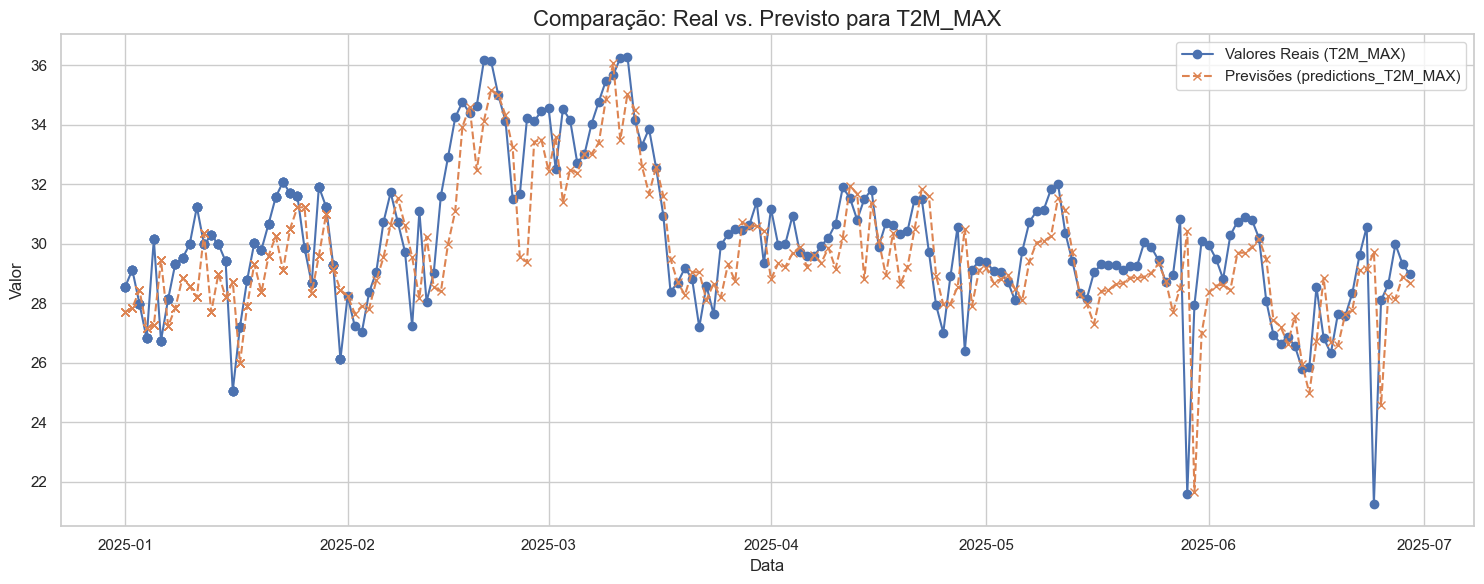

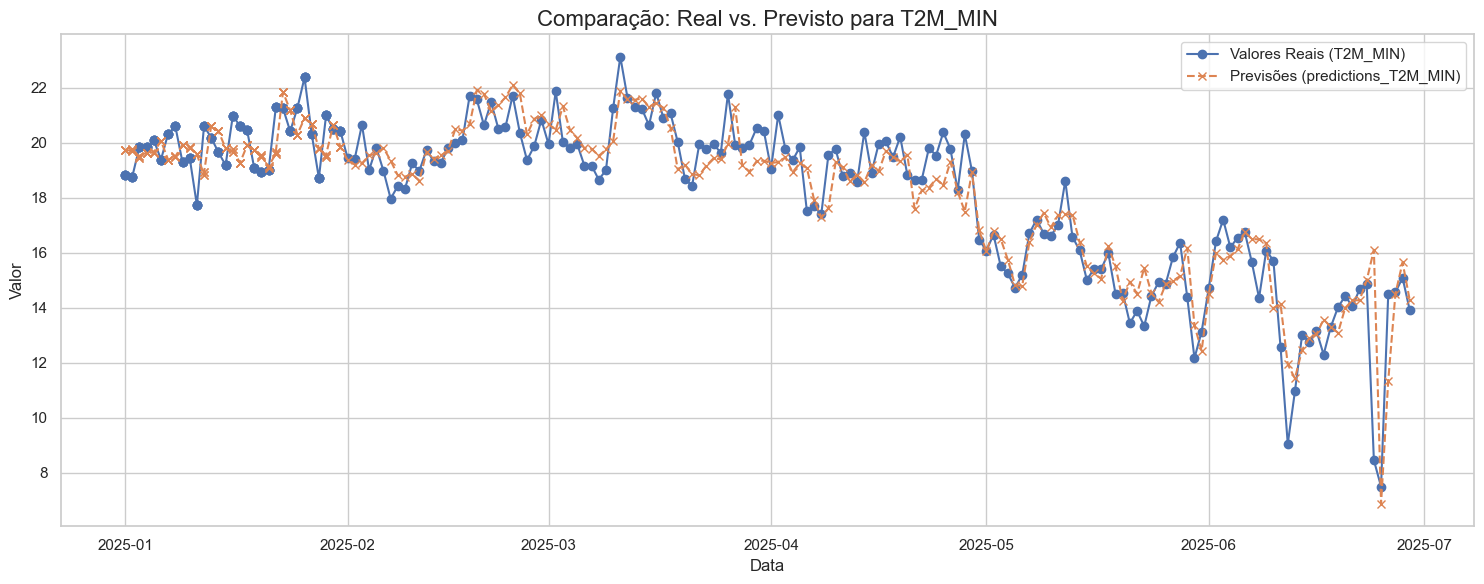

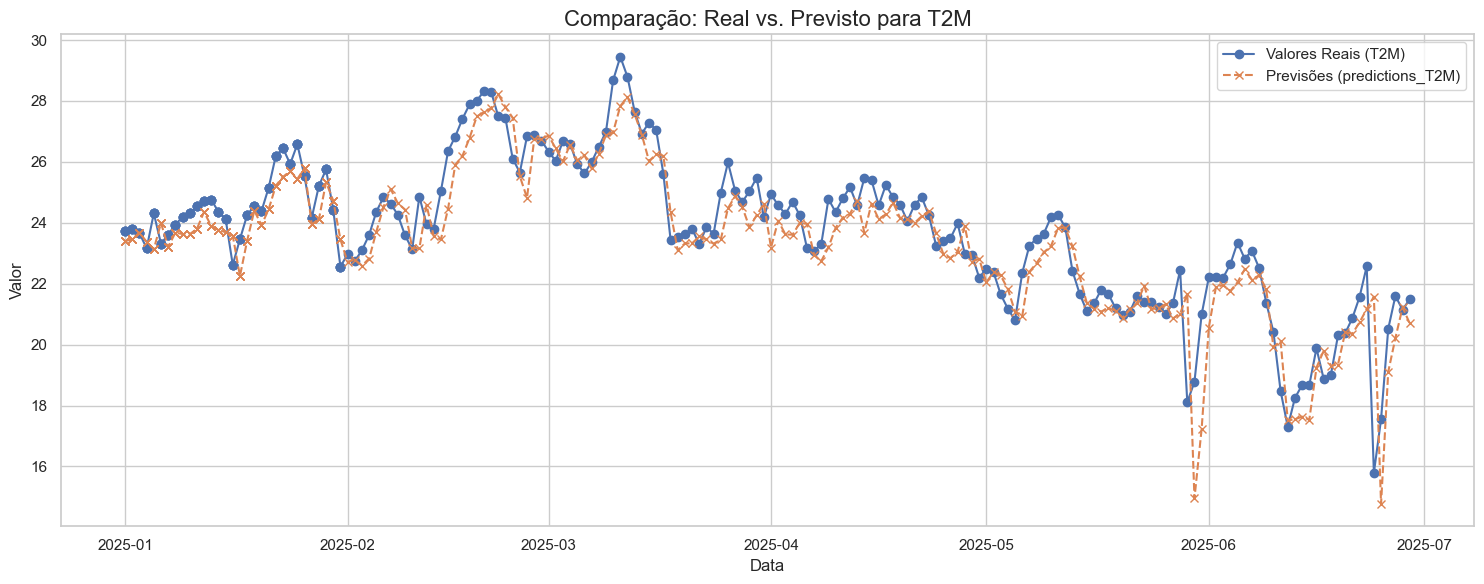

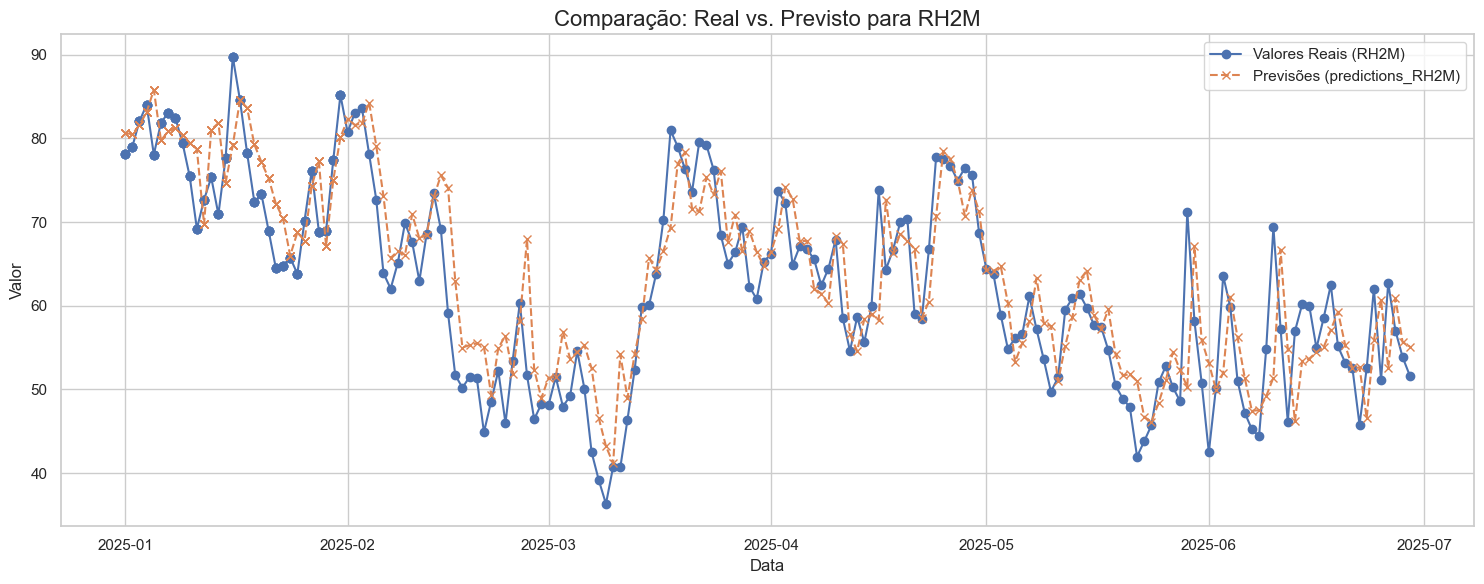

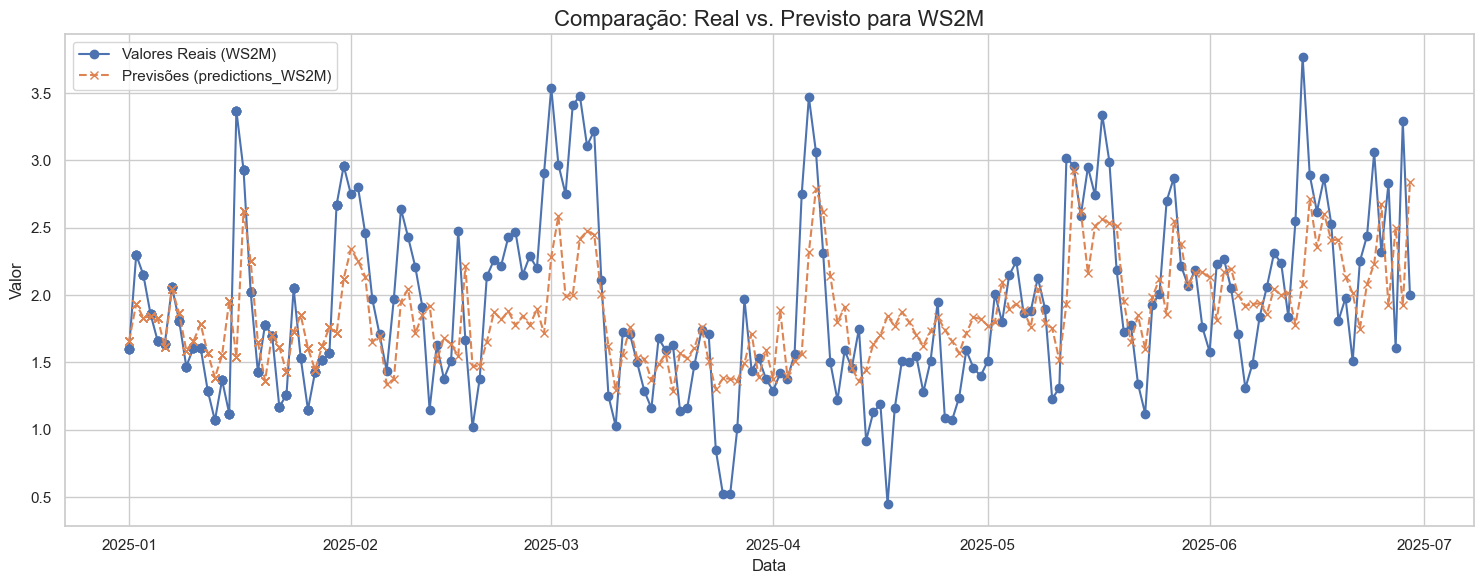

In [30]:
plot_real_vs_predicted_from_df(performance_df)